In [1]:
import numpy as np
import sklearn.gaussian_process as gp

from scipy.stats import norm
from scipy.optimize import minimize

import warnings
warnings.filterwarnings("ignore")

from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import math
import matplotlib.pyplot as plt

In [2]:
def expected_improvement(x, model, evaluated_loss, greater_is_better=False, n_params=1):

    x_to_predict = x.reshape(-1, n_params) 
    
    # mu, sigma в зависимости от модели
    if model.__class__.__name__ == 'GaussianProcessRegressor':
        mu, sigma = model.predict(x_to_predict, return_std=True)

    elif model.__class__.__name__ == 'RandomForestRegressor':
        estimators = model.estimators_
        values = [est.predict(x_to_predict) for est in estimators]
        values = np.array(values)
        mu = np.mean(values, axis = 0)
        sigma = np.std(values, axis = 0)
    
    
    # Находим оптимальный лосс, из старых значений
    if greater_is_better:
        loss_optimum = np.max(evaluated_loss)
    else:
        loss_optimum = np.min(evaluated_loss)

    # if False or 0 == -1, else = 1
    scaling_factor = (-1) ** (not greater_is_better)

    # игнор ошибок при делении
    with np.errstate(divide='ignore'):
        # Считаем З
        Z = scaling_factor * (mu - loss_optimum) / sigma
        
        # возвращает 100к експ емпрувментов
        expected_improvement = scaling_factor * (mu - loss_optimum) * norm.cdf(Z) + sigma * norm.pdf(Z)
        expected_improvement[sigma == 0.0] == 0.0
        #print('Z_max', np.max(expected_improvement))        

    return -1 * expected_improvement


def bayesian_optimisation(model, n_iters, sample_loss, bounds, n_pre_samples=5,
                          random_search=False, epsilon=1e-7, greater_is_better=False):

    x_list = []
    y_list = []

    n_params = bounds.shape[0]

    # Стартовые точки
    for params in np.random.uniform(bounds[:, 0], bounds[:, 1], (n_pre_samples, bounds.shape[0])):
        # Делаем параметры, считаем функцию для них
        x_list.append(params)
        y_list.append(sample_loss(params))

    xp = np.array(x_list)
    yp = np.array(y_list)


    for n in range(n_iters):
        model.fit(xp, yp)
        
        # Генерируем (random_search, len(params)) чисел в нашем промежутке
        x_random = np.random.uniform(bounds[:, 0], bounds[:, 1], size=(random_search, n_params))

        # считаем 100к ЕИ, берем наилучшее
        ei = -1 * expected_improvement(x_random, model, yp, greater_is_better=greater_is_better, 
                                       n_params=n_params)
        next_sample = x_random[np.argmax(ei), :]
            
        # При частом попадании в одну область (епсилон) - тыкаем в рандом
        if np.any(np.abs(next_sample - xp) <= epsilon):
            #print(n, 'GONNA RNG')
            next_sample = np.random.uniform(bounds[:, 0], bounds[:, 1], bounds.shape[0])

        # Sample loss for new set of parameters
        cv_score = sample_loss(next_sample)

        # Update lists
        x_list.append(next_sample)
        y_list.append(cv_score)

        # Update xp and yp
        xp = np.array(x_list)
        yp = np.array(y_list)

    return xp, yp

In [4]:
def pltlist(topy, greater_is_better = False):
    plotlist = []
    y_max = 0

    for y in topy:
        if greater_is_better == True:
            if y > y_max:
                y_max = y
        else:
            if y < y_max:
                y_max = y
                
        plotlist.append(y_max)

    return np.array(plotlist)

# Rastrigin func

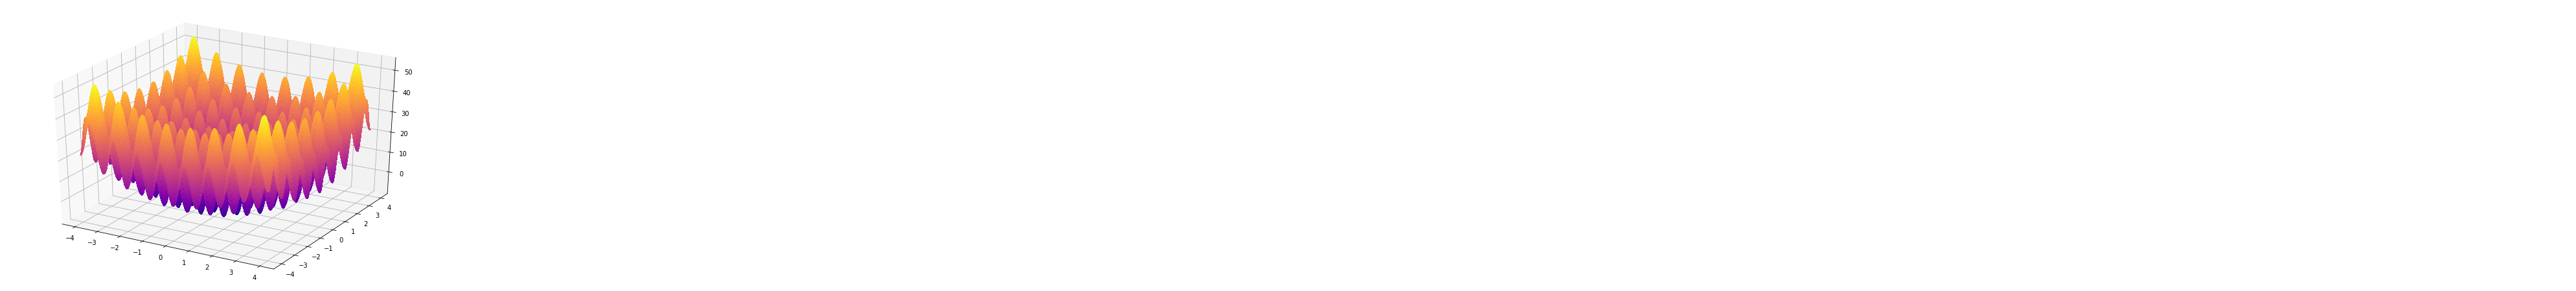

In [5]:
def rastrigin(*X, **kwargs):
    A = kwargs.get('A', 10)
    return A + sum([(x**2 - A * np.cos(2 * math.pi * x)) for x in X])

X = np.linspace(-4, 4, 200)    
Y = np.linspace(-4, 4, 200)    

X, Y = np.meshgrid(X, Y)
Z = rastrigin(X, Y, A=10)

fig = plt.figure(figsize=(12,8))
ax = fig.gca(projection='3d')

ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.plasma, linewidth=0, antialiased=False)
plt.show()

def rastrigin_loss(params):
    return rastrigin(params[0], params[1], A=10)

In [6]:
X = np.linspace(-4, 4, 201) 
Y = np.linspace(-4, 4, 201) 

# We need the cartesian combination of these two vectors
param_grid = np.array([[x, y] for y in Y for x in X]) 

real_loss_rastrigin = [rastrigin_loss(params) for params in param_grid] # считаем лосс для каждого

# The maximum is at:
param_grid[np.array(real_loss_rastrigin).argmin(), :]

array([0., 0.])

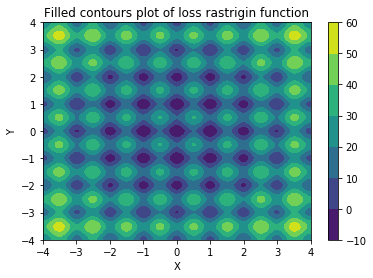

In [7]:
C, G = np.meshgrid(X, Y)
plt.figure()
cp = plt.contourf(C, G, np.array(real_loss_rastrigin).reshape(C.shape))
plt.colorbar(cp)
plt.title('Filled contours plot of loss rastrigin function')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

In [8]:
rastrigin_loss([0, 0])

-10.0

## SMBO

In [10]:
bounds = np.array([[-4, 4], [-4, 4]])

kernel = gp.kernels.Matern()
model_gp = gp.GaussianProcessRegressor(kernel=kernel,
                                    alpha=1e-5,
                                    n_restarts_optimizer=10,
                                    normalize_y=True)


xp_gp, yp_gp = bayesian_optimisation(model_gp, n_iters = 200, 
                               sample_loss=rastrigin_loss, 
                               bounds=bounds,
                               n_pre_samples=3,
                               random_search=100000,
                               epsilon = 1e-4)

print('min iter, min value:', yp_gp.argmin(), xp_gp[yp_gp.argmin()])

min iter, min value: 184 [ 0.00226051 -0.00064561]


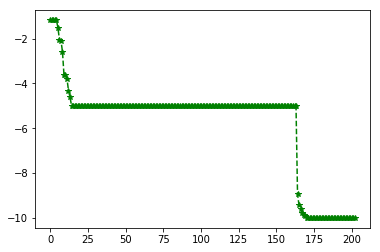

In [11]:
listy_gp = pltlist(yp_gp)
plt.plot(listy_gp, '*g--')
plt.show()

## SMAC

In [12]:
from sklearn.ensemble import RandomForestRegressor


model_rf = RandomForestRegressor(n_estimators = 200,
                              random_state = 42, max_depth = 15)

xp_rf, yp_rf = bayesian_optimisation(model_rf, n_iters=200, 
                               sample_loss=rastrigin_loss, 
                               bounds=bounds,
                               n_pre_samples=3,
                               random_search=100000,
                               epsilon = 1e-4)

print('min iter, min value:', yp_rf.argmin(), xp_rf[yp_rf.argmin()])

min iter, min value: 52 [-0.00363747  0.00056885]


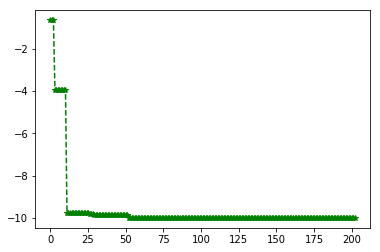

In [13]:
listy_rf = pltlist(yp_rf)
plt.plot(listy_rf, '*g--')
plt.show()

## Rand Search

In [14]:
def RandomSearch(func, bounds, n_iter = 20):
    x_list = [params for params in np.random.uniform(bounds[:, 0], bounds[:, 1], (n_iter, bounds.shape[0]))]
    y_list = [func(params) for params in np.random.uniform(bounds[:, 0], bounds[:, 1], (n_iter, bounds.shape[0]))]

    x = np.array(x_list)
    y = np.array(y_list)
    return x, y
    

In [31]:
bounds = np.array([[-4, 4], [-4, 4]])
x_rs, y_rs = RandomSearch(rastrigin_loss, bounds, n_iter = 500)

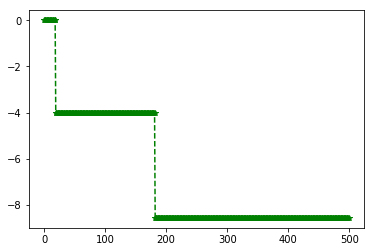

In [32]:
pltrngsearch = pltlist(y_rs)
plt.plot(pltrngsearch, 'g*--')
plt.show()

## Try on Smoothness

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def plot_iteration(model, first_param_grid, sampled_params, sampled_loss, first_iter=0, alpha=1e-5,
                   greater_is_better=True, true_y=None, second_param_grid=None,
                   param_dims_to_plot=[0, 1], filepath=None, optimum=None):


    # Don't show the last iteration (next_sample is not available then)
    for i in range(first_iter, sampled_params.shape[0] - 1):
        model.fit(X=sampled_params[:(i + 1), :], y=sampled_loss[:(i + 1)])


        # Transform grids into vectors for EI evaluation
        param_grid = np.array([[first_param, second_param] for first_param in first_param_grid for second_param in second_param_grid])
     
    
        if model.__class__.__name__ == 'GaussianProcessRegressor':
            mu, std = model.predict(param_grid, return_std=True)
            ei = -1 * expected_improvement(param_grid, model, sampled_loss[:(i + 1)],
                                       greater_is_better=greater_is_better, n_params=2)
            
        elif model.__class__.__name__ == 'RandomForestRegressor':
            mu = model.predict(param_grid)
            ei = -1 * expected_improvement(param_grid, model, sampled_loss[:(i + 1)],
                                       greater_is_better=greater_is_better, n_params=2)
        else:
            raise ValueError('HiThere')

        fig, ax1, ax2 = _plot_loss_2d(first_param_grid, second_param_grid, 
                                      sampled_params[:(i+1), param_dims_to_plot], sampled_loss, 
                                      mu, ei, sampled_params[i + 1, param_dims_to_plot], optimum)


def _plot_loss_2d(first_param_grid, second_param_grid, sampled_params, sampled_loss, mu, ei, 
                  next_sample, optimum=None):
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,8), sharex=True, sharey=True)

    X, Y = np.meshgrid(first_param_grid, second_param_grid, indexing='ij')

    # EI contour plot
    cp = ax1.contourf(X, Y, ei.reshape(X.shape))
    plt.colorbar(cp, ax=ax1)
    ax1.set_title("Expected Improvement. Next sample will be (%.2f, %.2f)" % (next_sample[0], next_sample[1]))
    ax1.autoscale(False)
    ax1.axvline(next_sample[0], color='k')
    ax1.axhline(next_sample[1], color='k')
    ax1.scatter(next_sample[0], next_sample[1])
    ax1.set_xlabel("C")
    ax1.set_ylabel("gamma")

    # Loss contour plot
    cp2 = ax2.contourf(X, Y, mu.reshape(X.shape))
    plt.colorbar(cp2, ax=ax2)
    ax2.autoscale(False)
    ax2.scatter(sampled_params[:, 0], sampled_params[:, 1], zorder=1)
    ax2.axvline(next_sample[0], color='k')
    ax2.axhline(next_sample[1], color='k')
    ax2.scatter(next_sample[0], next_sample[1])
    ax2.set_title("Mean estimate of loss surface for iteration %d" % (sampled_params.shape[0]))
    ax2.set_xlabel("C")
    ax2.set_ylabel("gamma")

    if optimum is not None:
        ax2.scatter(optimum[0], optimum[1], marker='*', c='gold', s=150)

    return fig, ax1, ax2

In [33]:
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.datasets import make_classification

data, target = make_classification(n_samples=5000,
                                   n_features=30,
                                   n_informative=15)

# Кросс-валидационный скор для СВМ функции и параметров переданных в нее
def sample_loss(params):
    return cross_val_score(SVC(C=10 ** params[0], gamma=10 ** params[1], random_state=42),
                           X=data, y=target, scoring='roc_auc', cv=3).mean()

In [ ]:
lambdas = np.linspace(4, -4, 50)
gammas = np.linspace(4, -4, 40)

# We need the cartesian combination of these two vectors
param_grid = np.array([[C, gamma] for gamma in gammas for C in lambdas]) # Сетка переборов, 500 значений

real_loss = [sample_loss(params) for params in param_grid] # считаем лосс для каждого

# The maximum is at:
param_grid[np.array(real_loss).argmax(), :] # -2.42105263

In [34]:
%matplotlib inline

C, G = np.meshgrid(lambdas, gammas)
plt.figure()
cp = plt.contourf(C, G, np.array(real_loss).reshape(C.shape))
plt.colorbar(cp)
plt.title('Filled contours plot of loss function $\mathcal{L}$($\gamma$, $C$)')
plt.xlabel('$C$')
plt.ylabel('$\gamma')
plt.show()

NameError: name 'lambdas' is not defined

## SMBO!


In [35]:
bounds = np.array([[-4, 1], [-4, 1]])

kernel = gp.kernels.Matern()
model_gp = gp.GaussianProcessRegressor(kernel=kernel,
                                    alpha=1e-5,
                                    n_restarts_optimizer=10,
                                    normalize_y=True)


xp_gp, yp_gp = bayesian_optimisation(model_gp, n_iters=60, 
                               sample_loss=sample_loss, 
                               bounds=bounds,
                               n_pre_samples=3,
                               random_search=100000,
                               greater_is_better = True,
                                    epsilon = 1e-5)

print('min iter, min value:', yp_gp.argmax(), xp_gp[yp_gp.argmax()])

min iter, min value: 59 [ 0.63412185 -1.72449953]


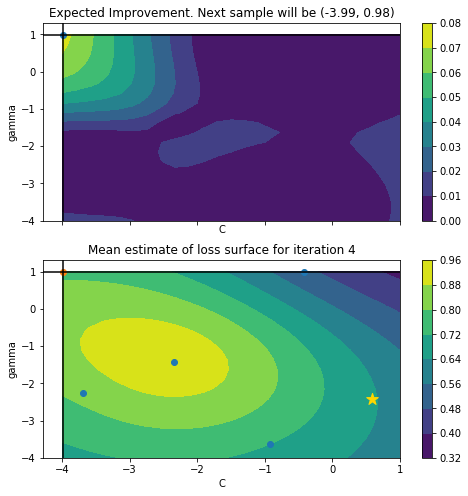

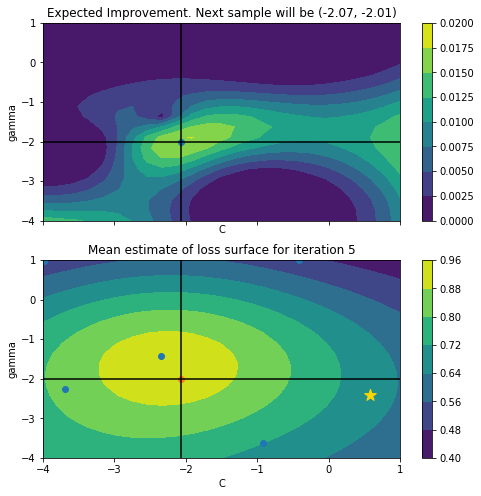

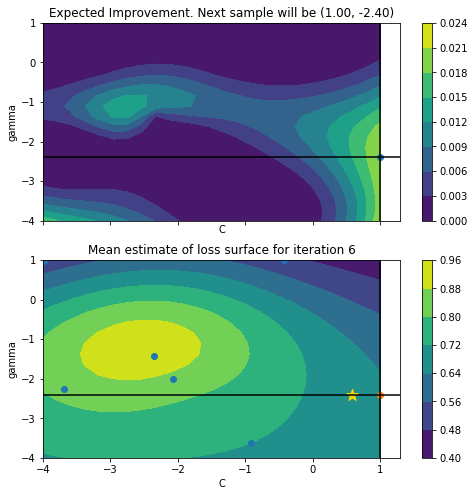

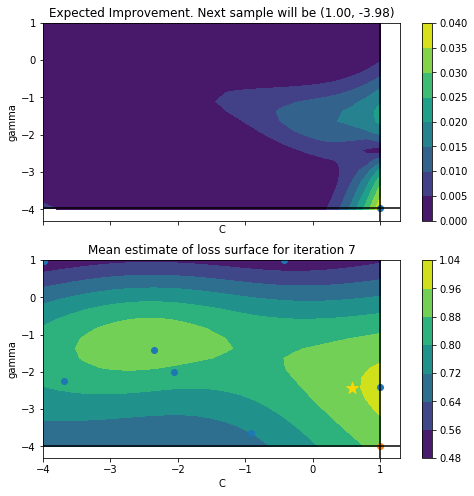

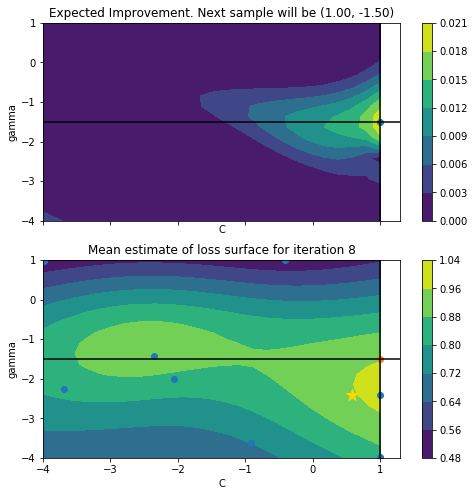

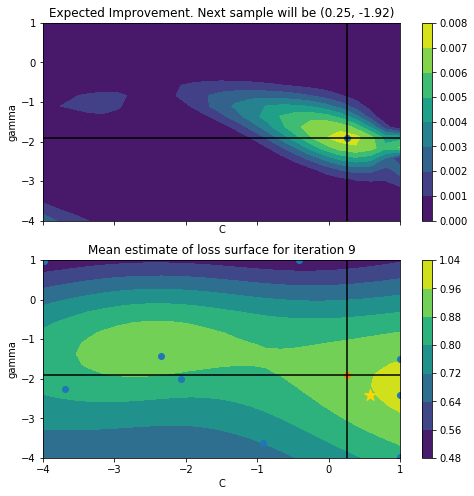

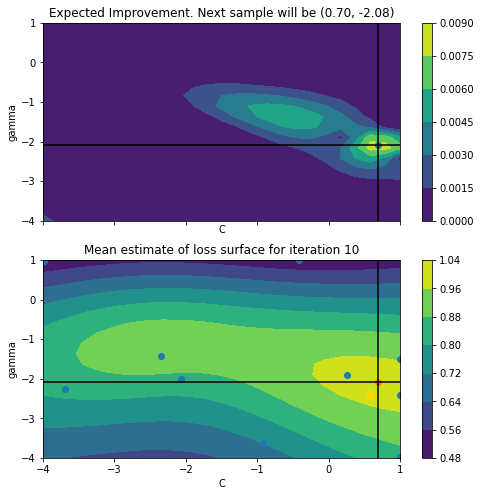

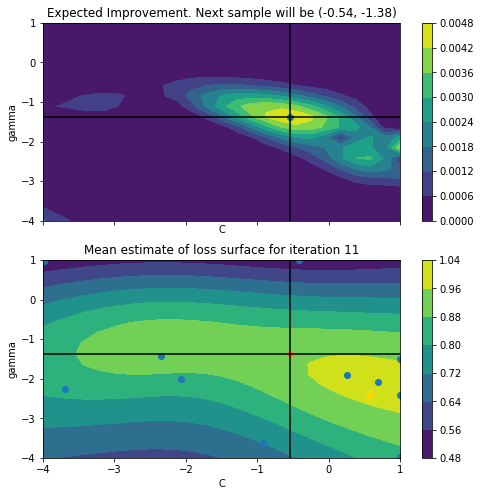

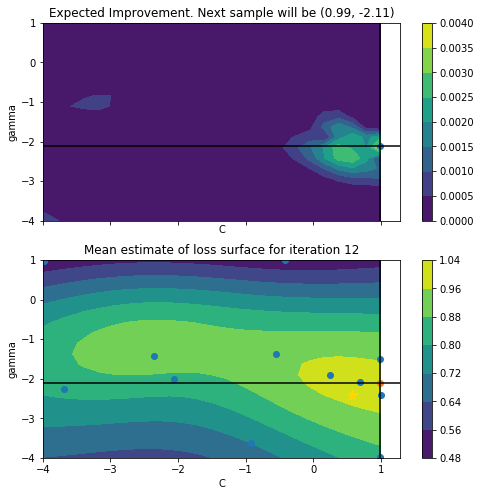

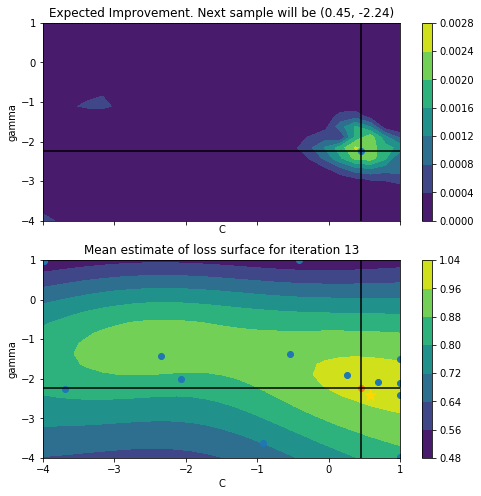

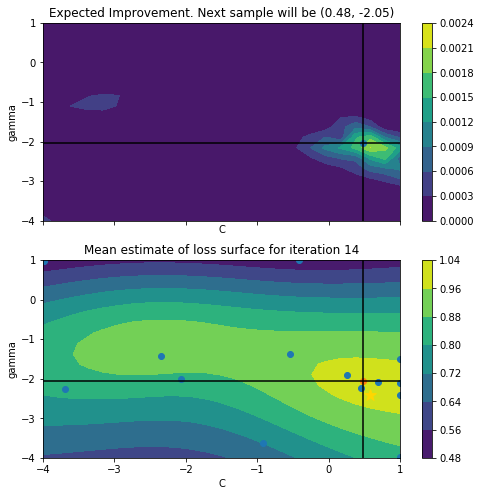

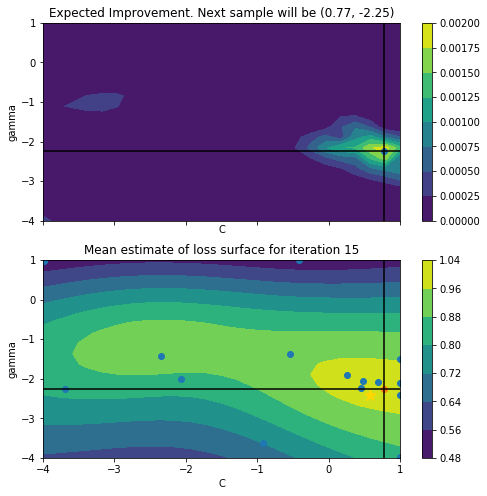

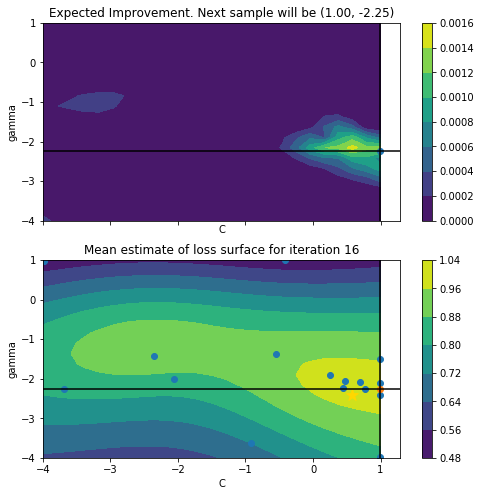

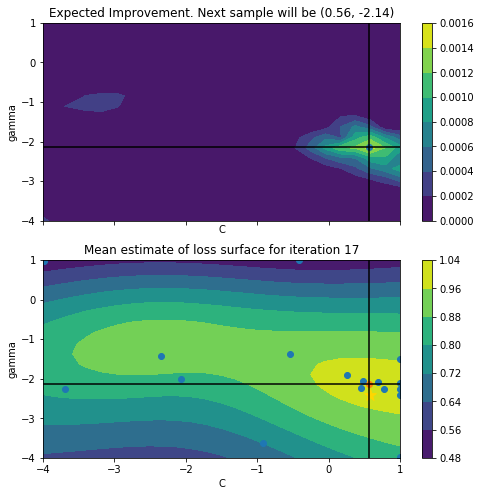

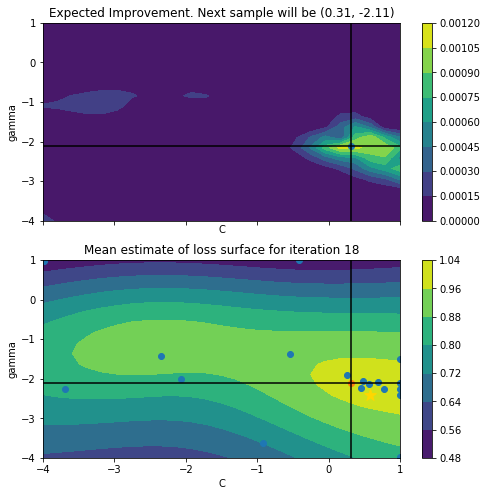

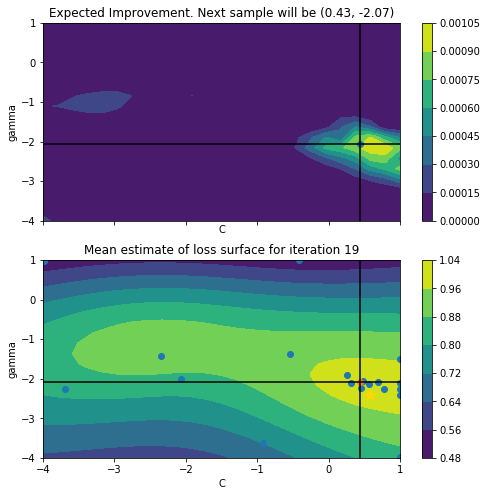

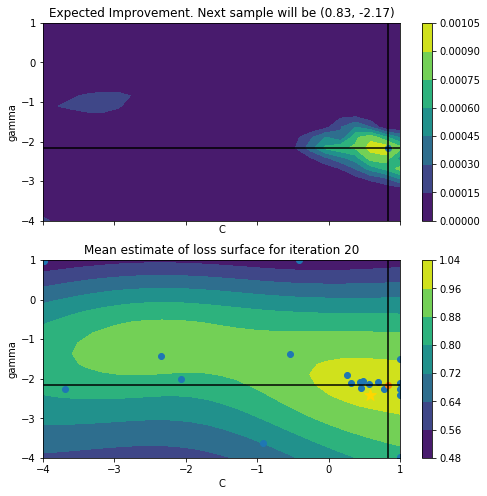

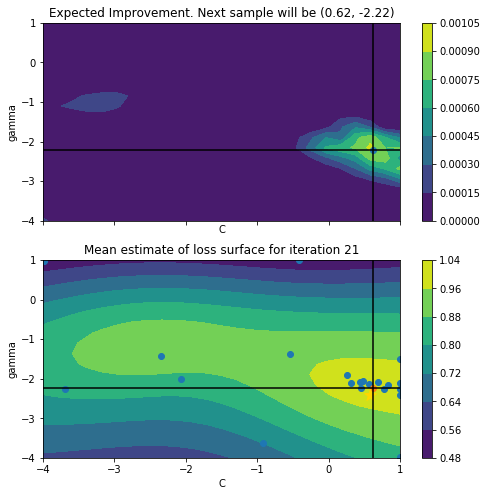

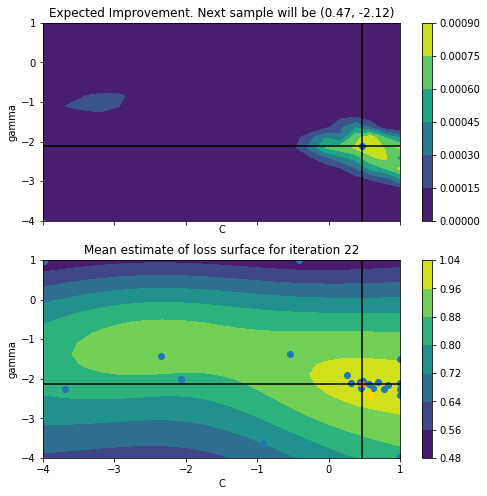

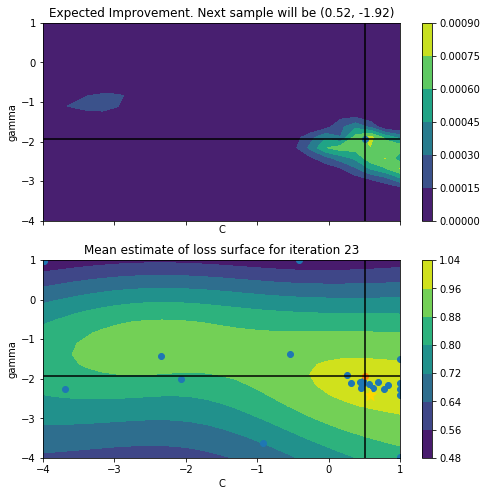

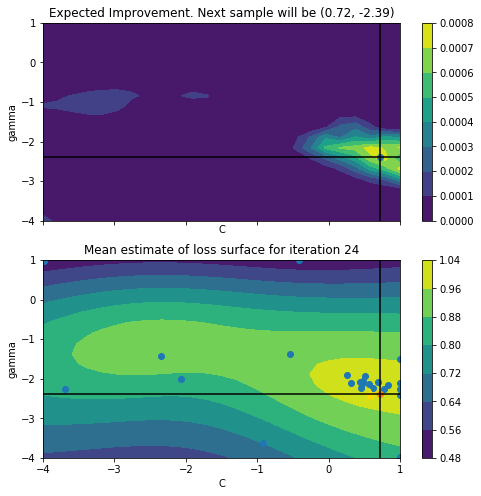

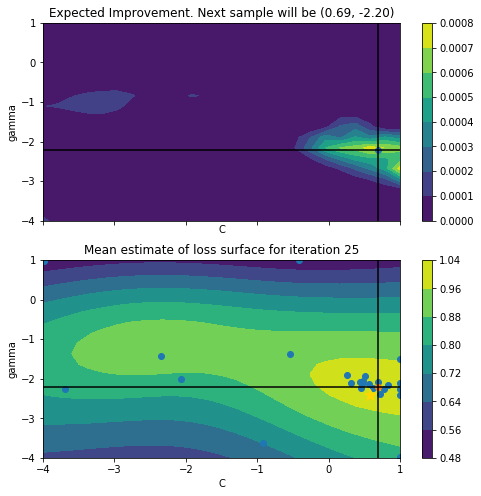

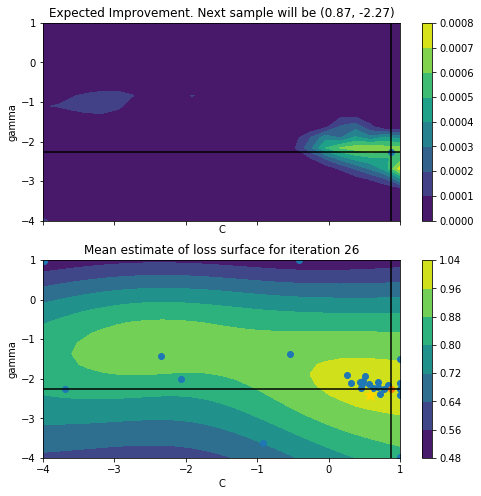

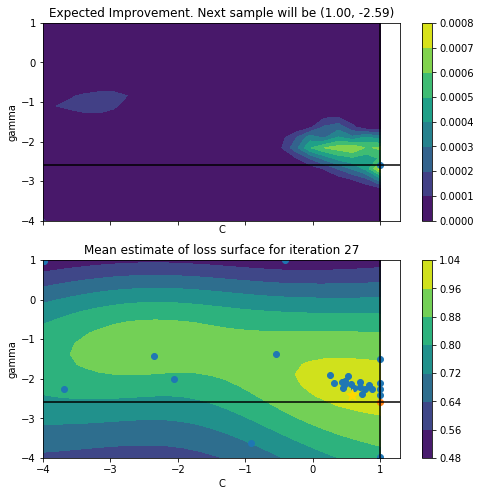

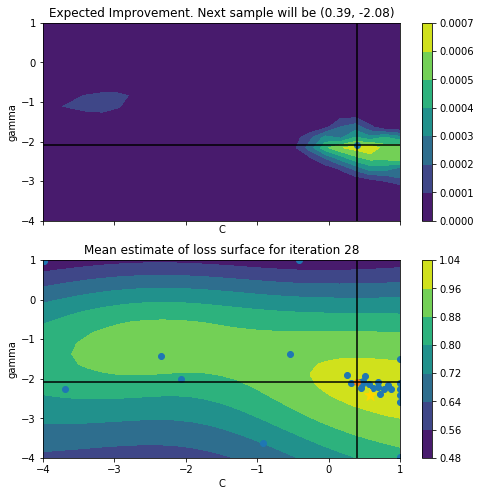

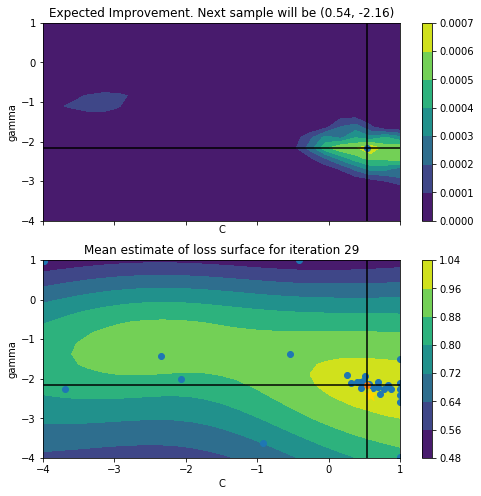

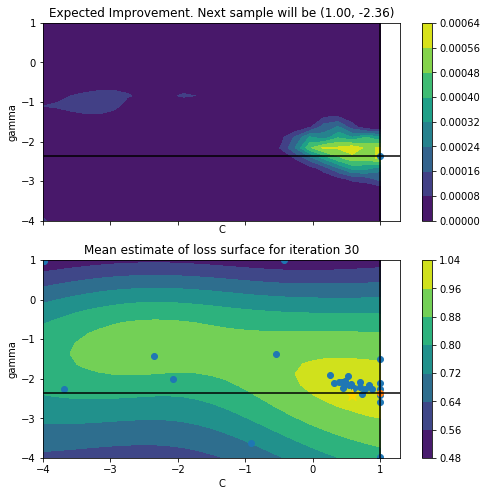

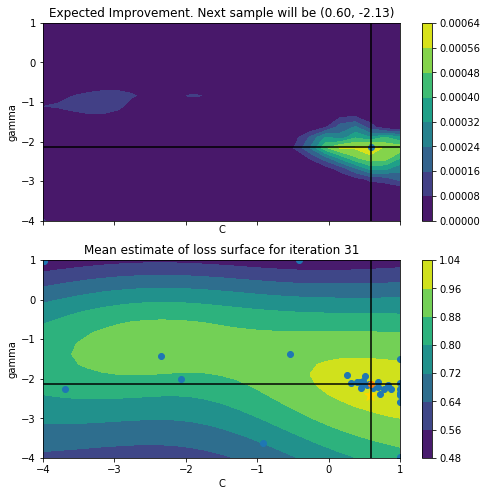

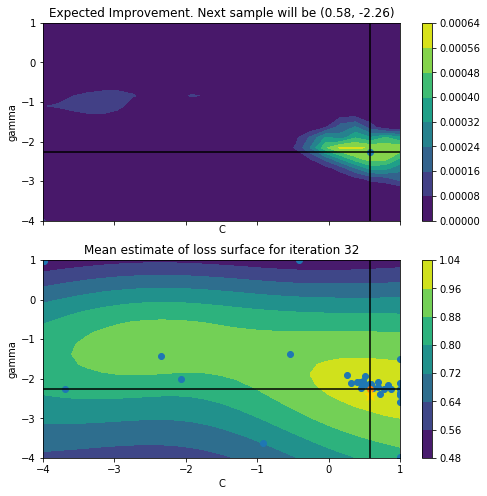

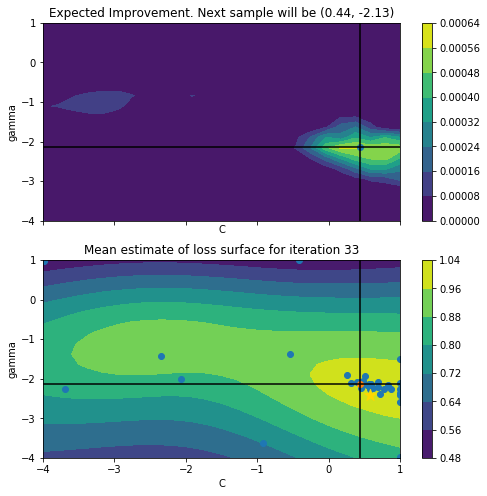

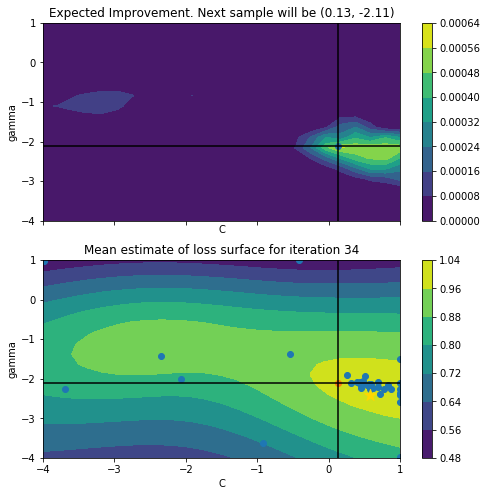

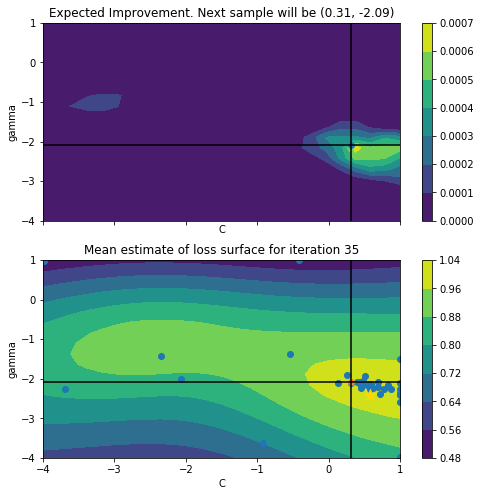

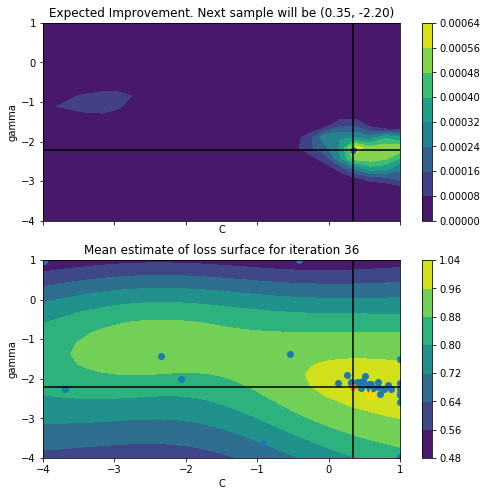

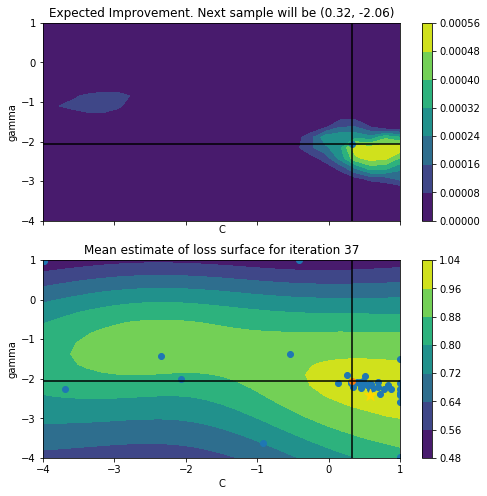

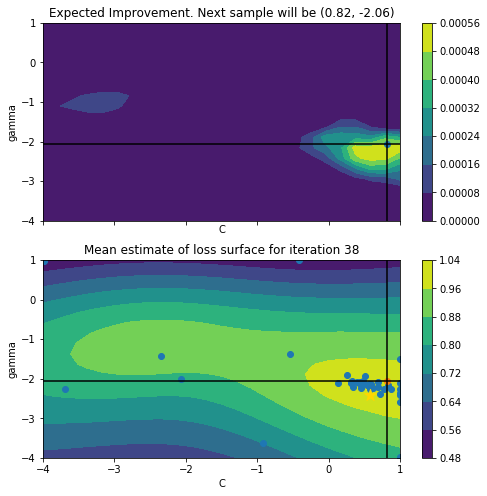

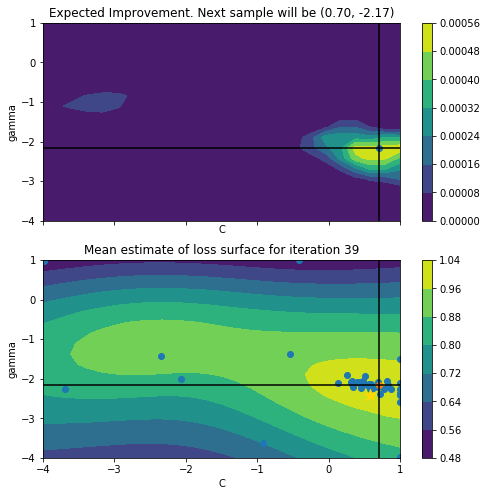

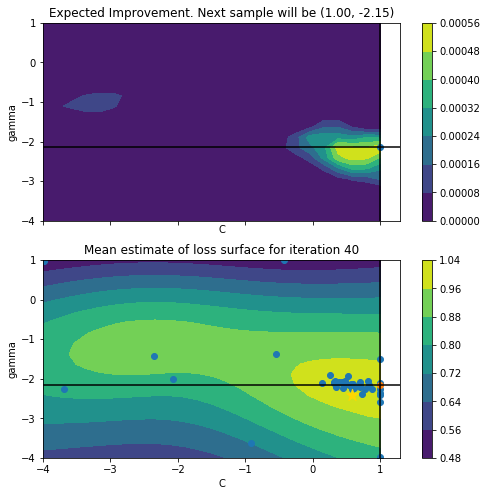

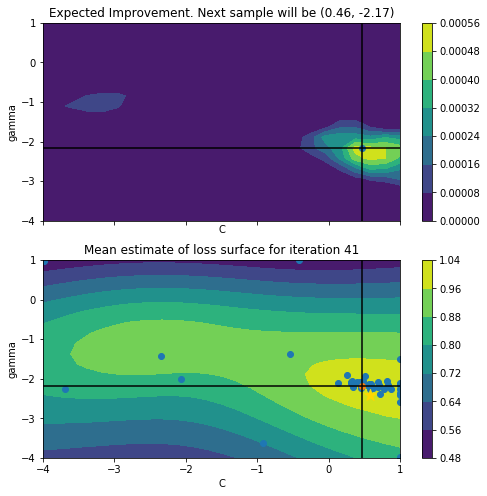

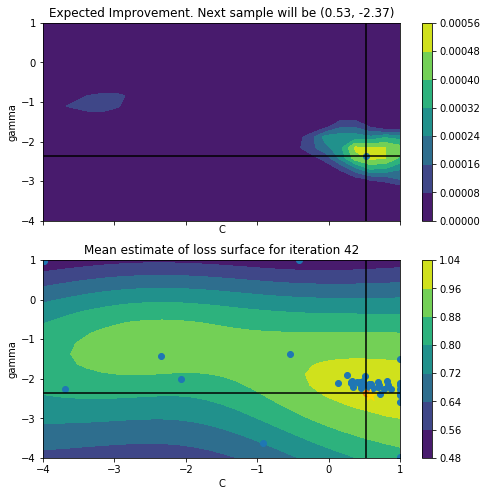

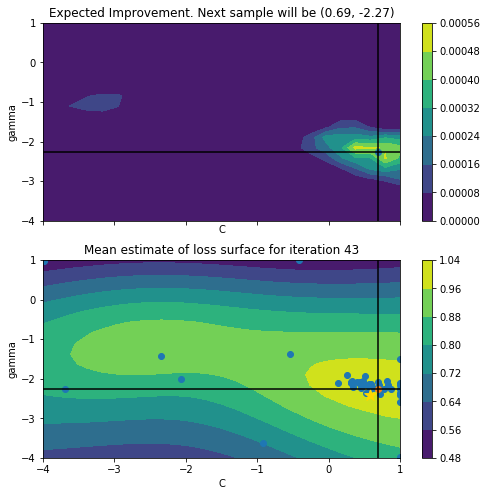

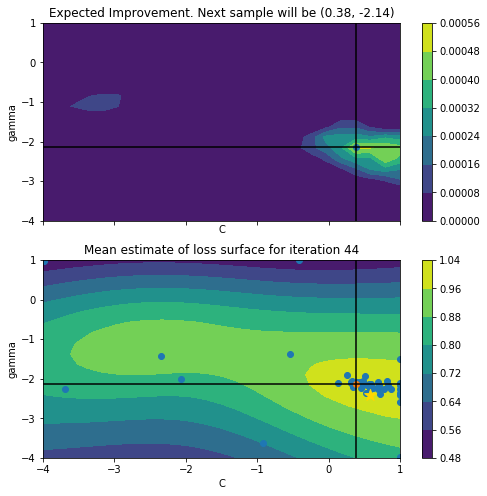

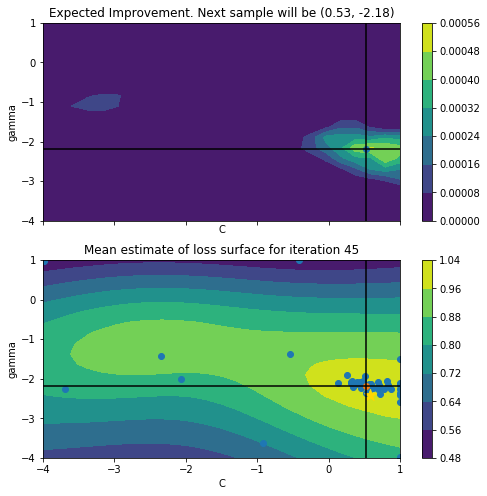

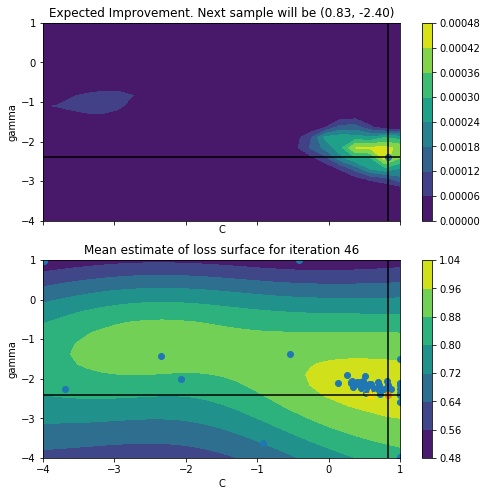

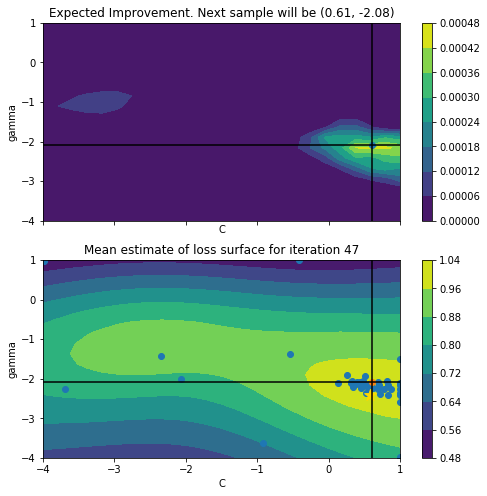

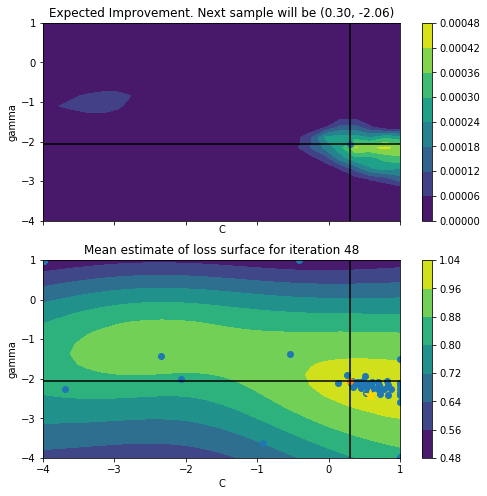

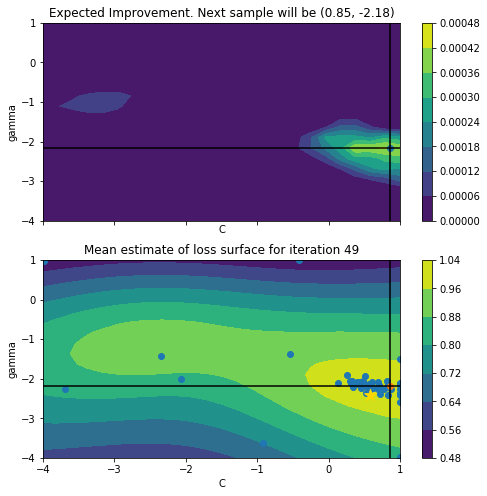

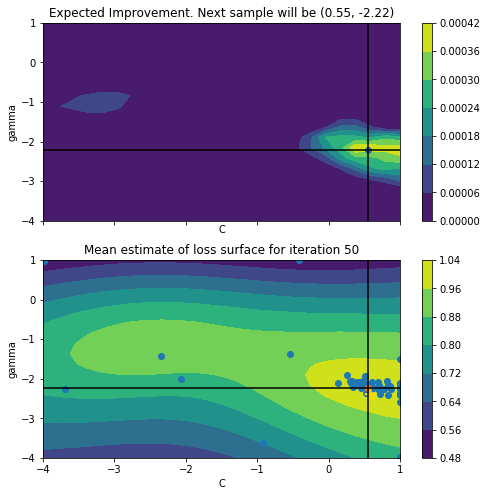

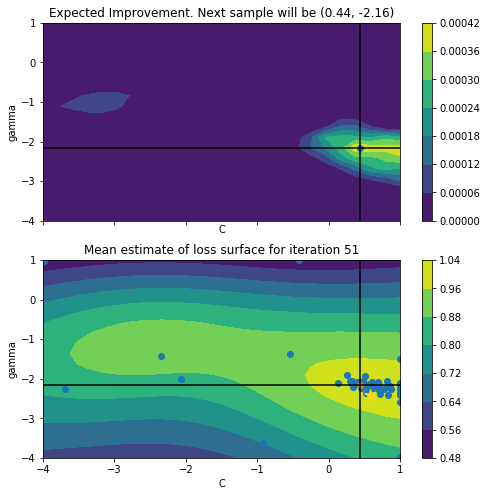

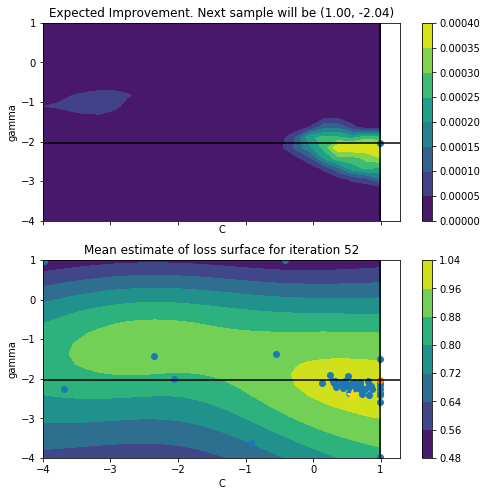

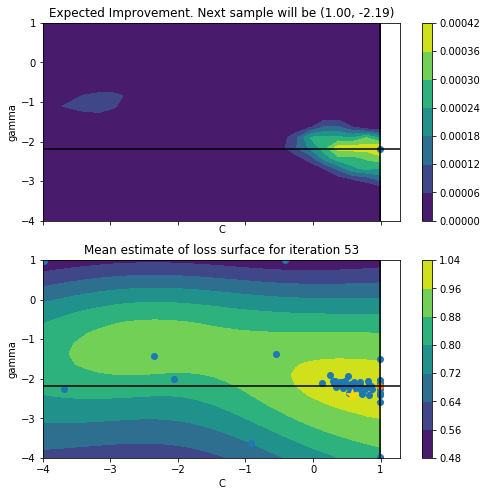

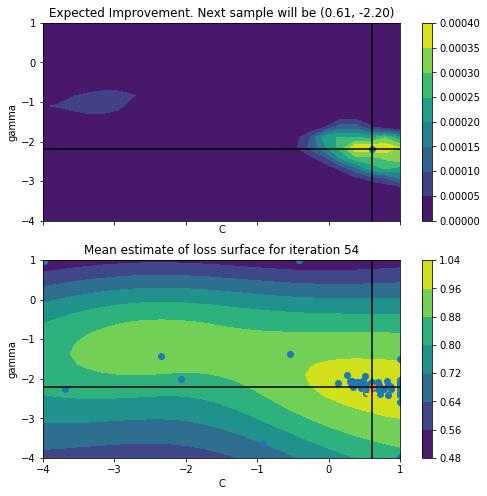

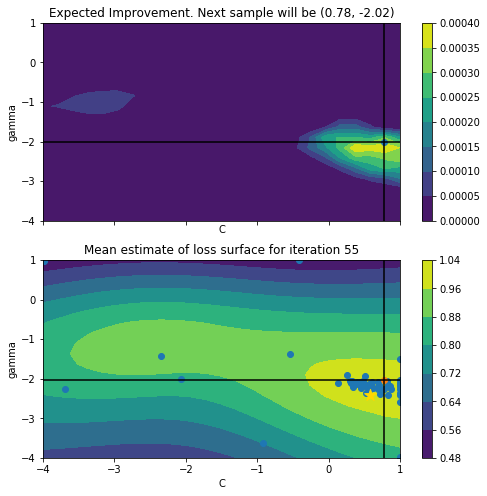

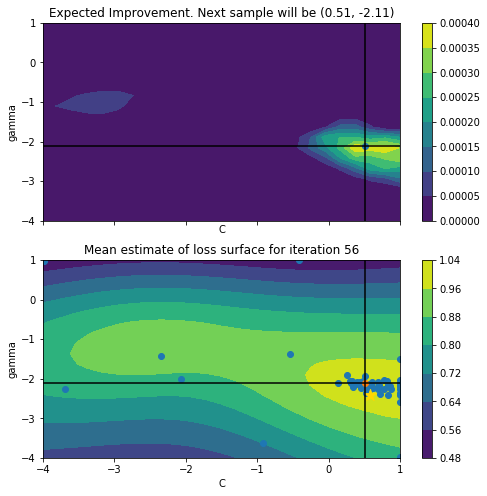

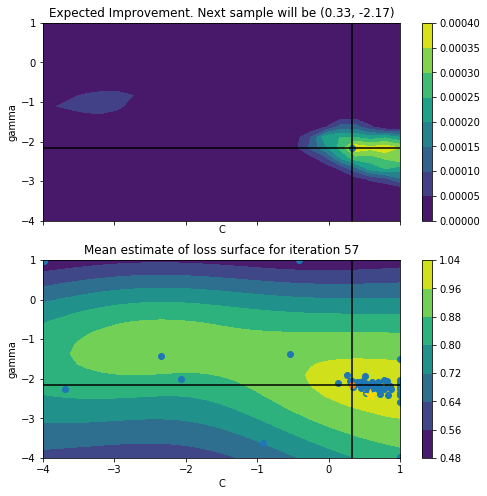

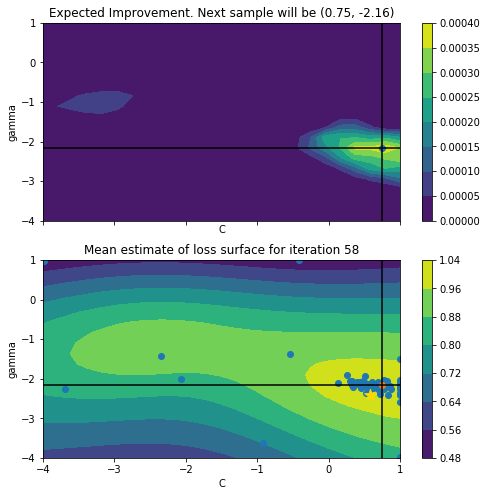

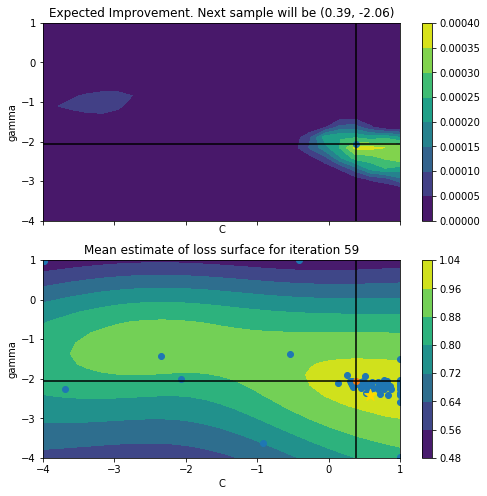

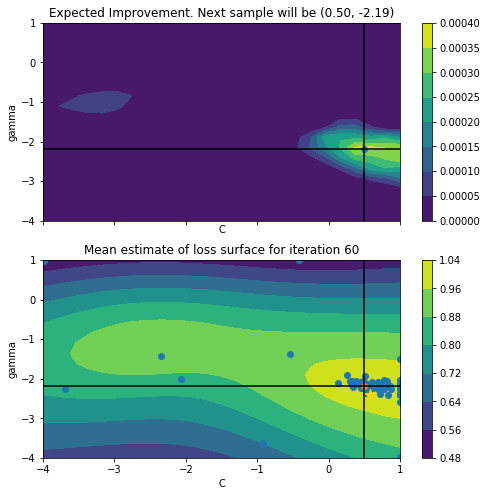

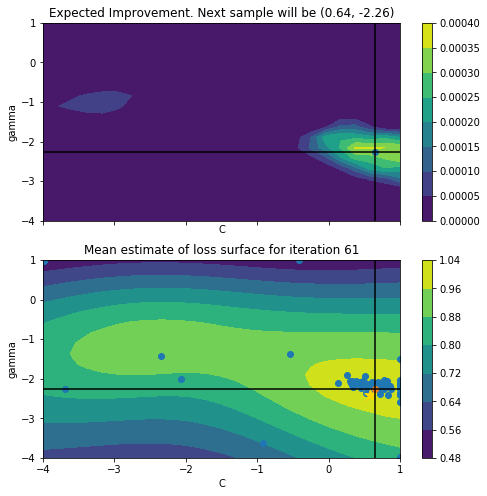

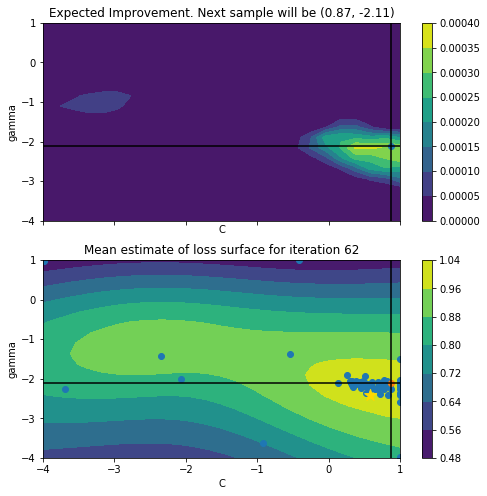

In [108]:
lambdas = np.linspace(1, -4, 25)
gammas = np.linspace(1, -4, 20)

plot_iteration(model_gp, lambdas, xp_gp, yp_gp, first_iter=3, 
               second_param_grid=gammas, optimum=[0.58333333, -2.42105263])

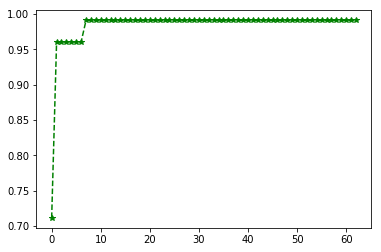

In [37]:
listy_gp = pltlist(yp_gp, greater_is_better = True)
plt.plot(listy_gp, '*g--')
plt.show()

### SMAC

In [38]:
from sklearn.ensemble import RandomForestRegressor
bounds = np.array([[-4, 1], [-4, 1]])
model_rf = RandomForestRegressor(n_estimators = 50,
                              random_state = 42, max_depth = 15)

xp_rf, yp_rf = bayesian_optimisation(model_rf, n_iters=50, 
                               sample_loss=sample_loss, 
                               bounds=bounds,
                               n_pre_samples=3,
                               random_search=100000,
                              greater_is_better = True,
                                    epsilon = 1e-4)

print('min iter, min value:', yp_rf.argmax(), xp_rf[yp_rf.argmax()])

min iter, min value: 46 [-0.64558798 -1.96737834]


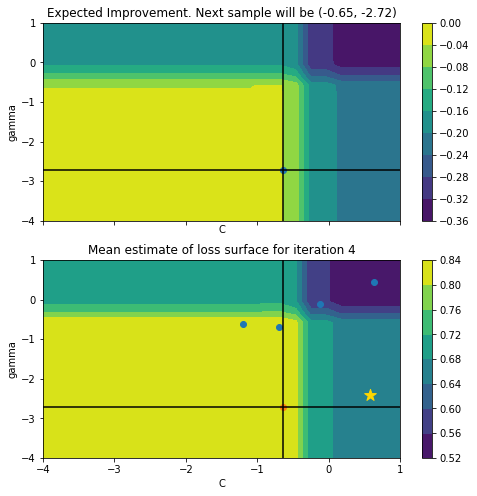

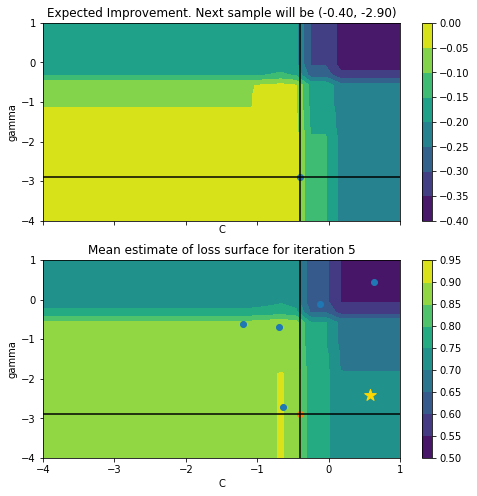

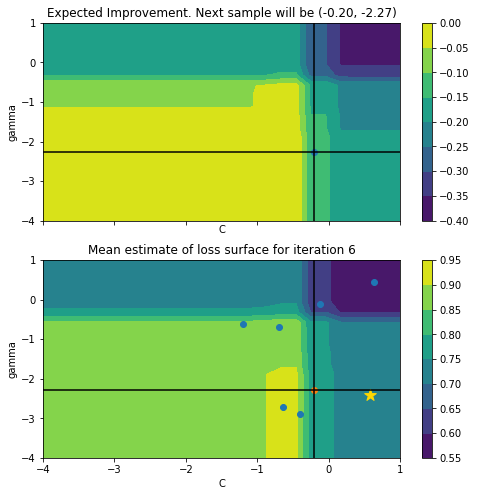

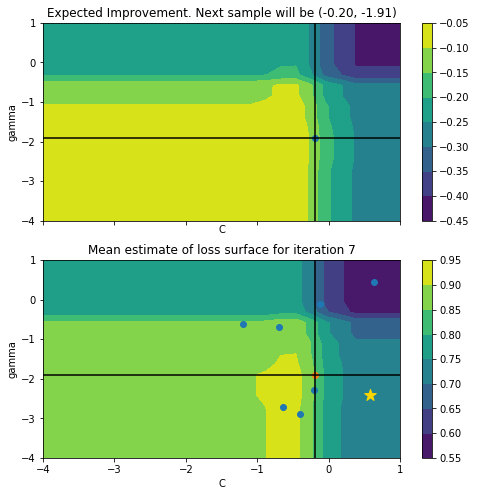

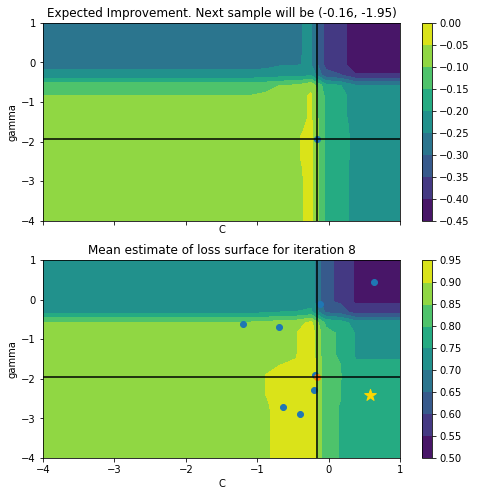

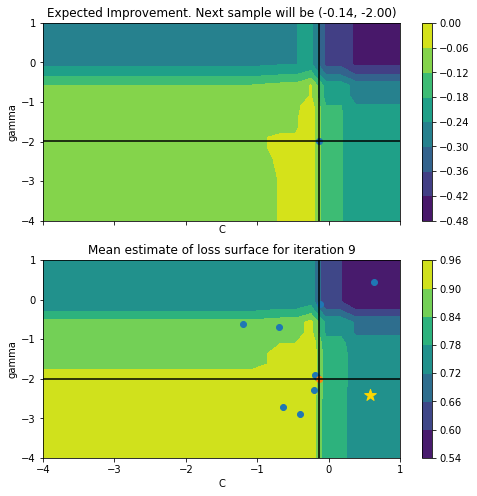

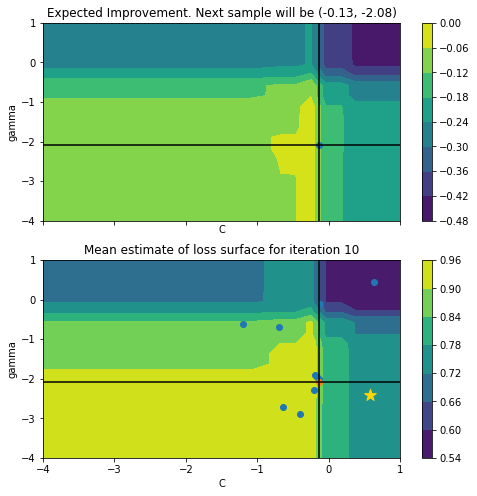

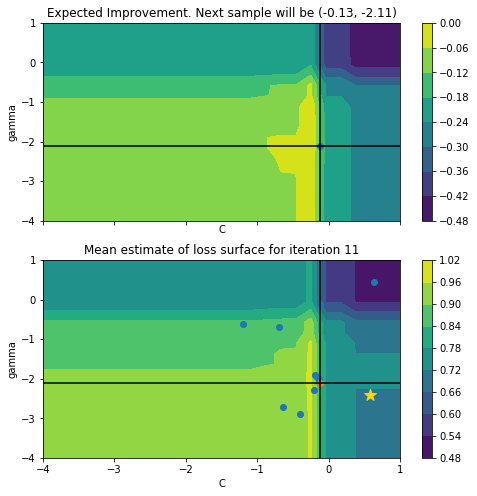

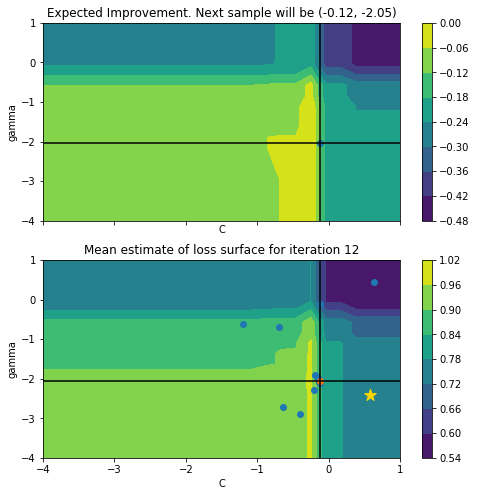

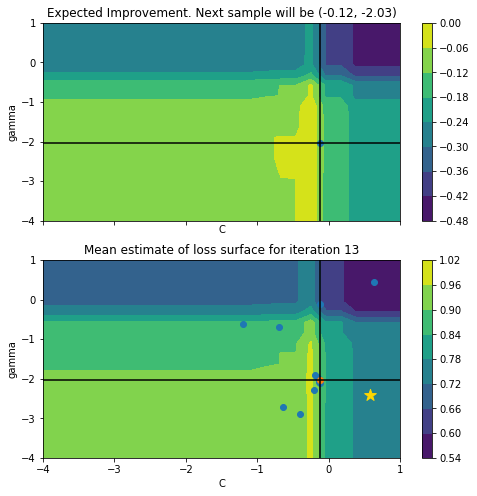

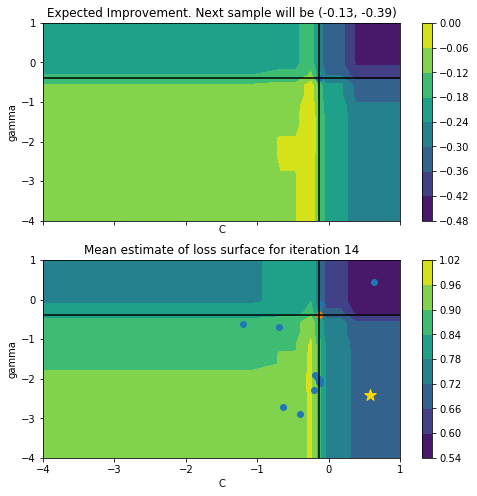

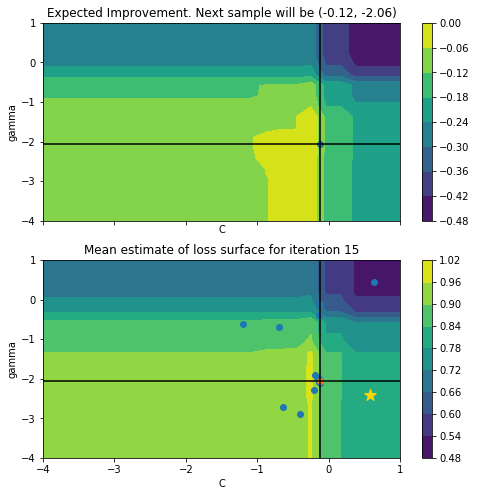

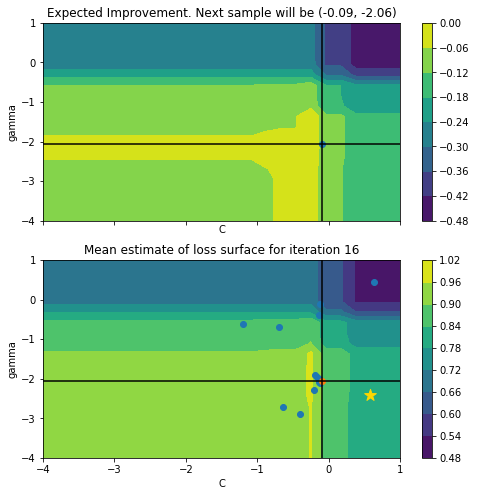

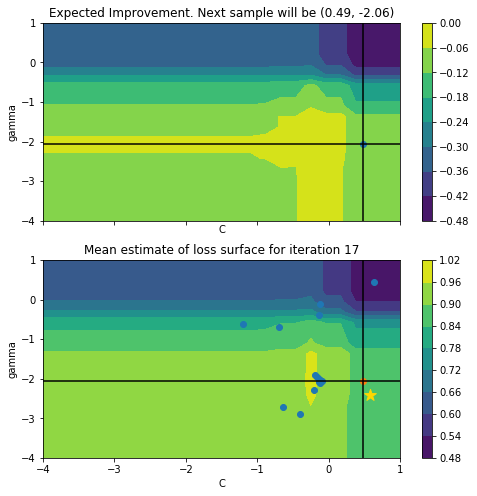

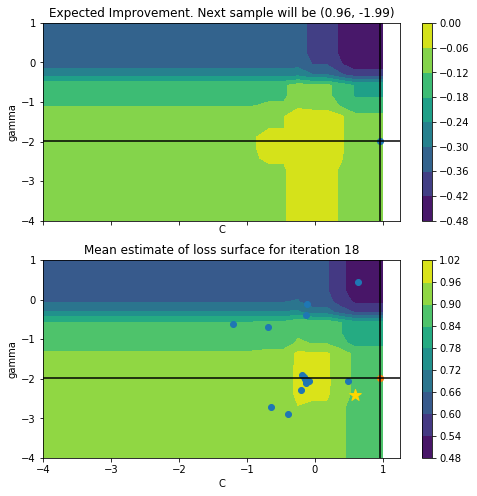

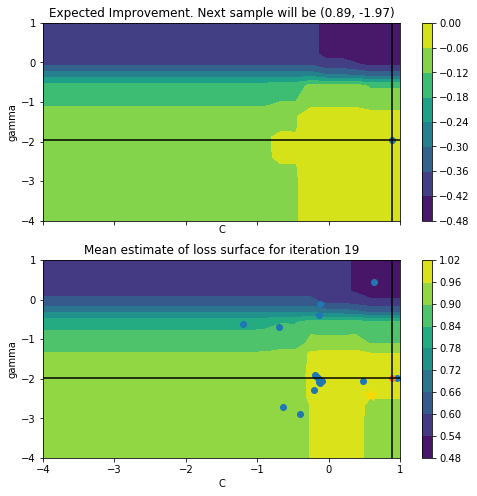

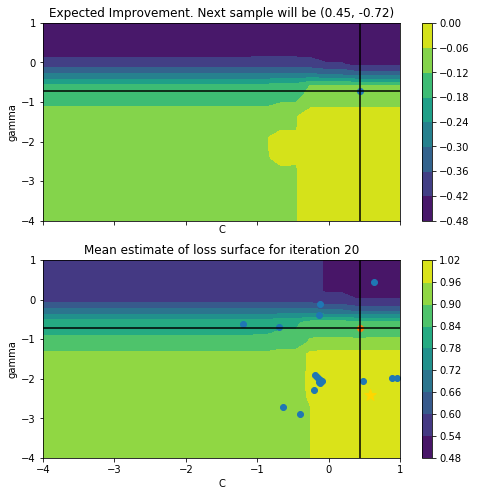

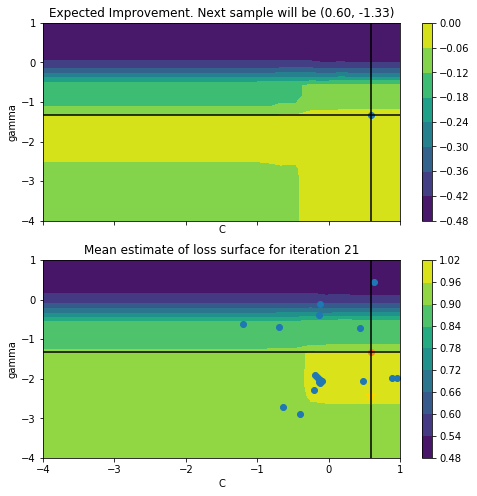

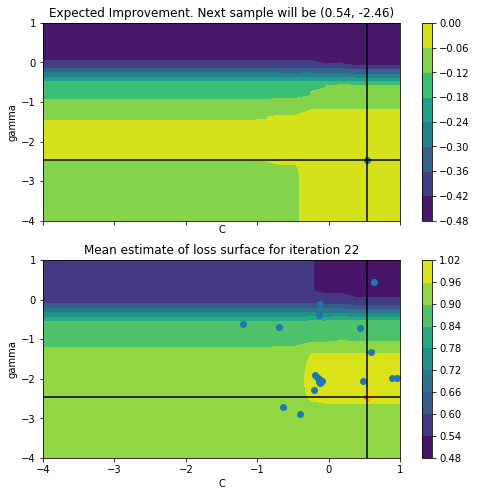

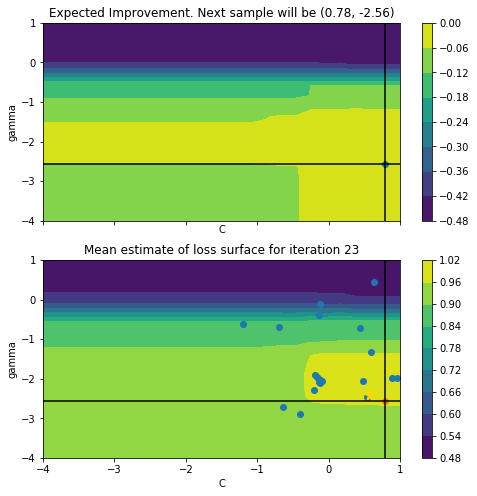

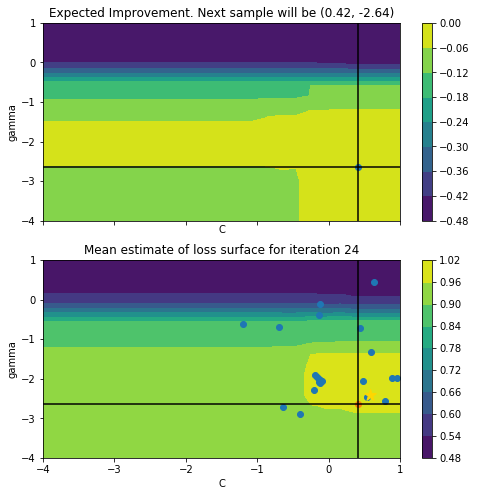

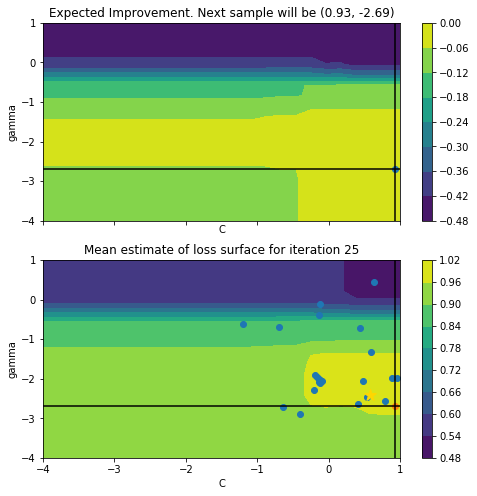

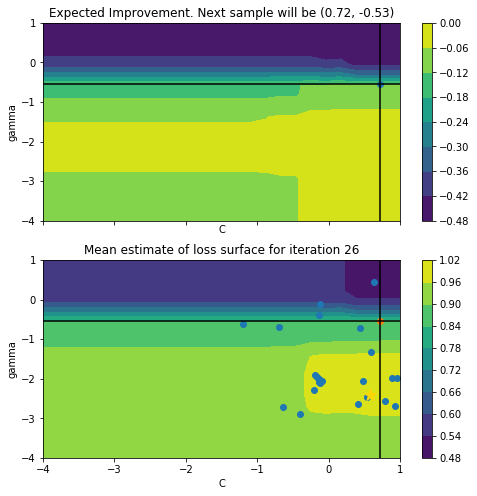

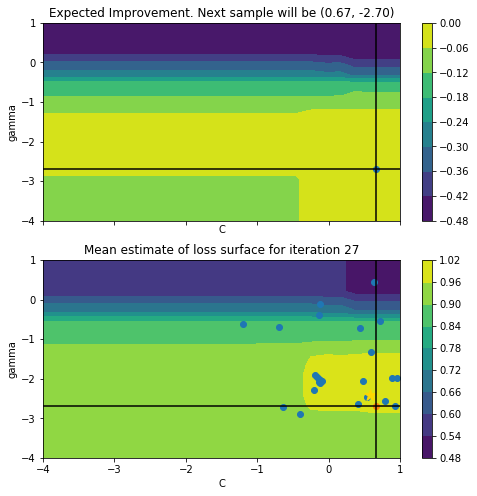

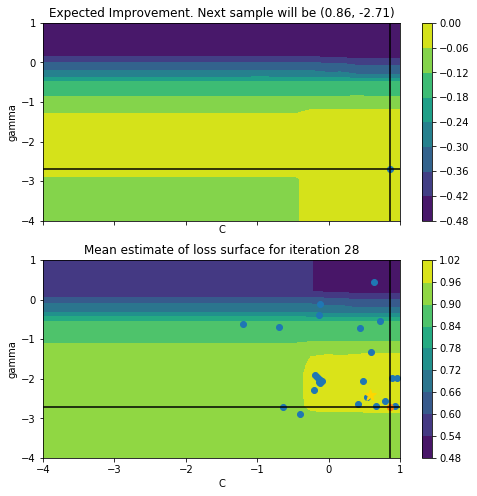

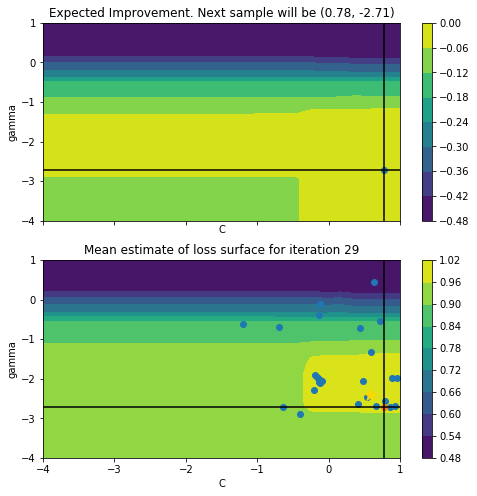

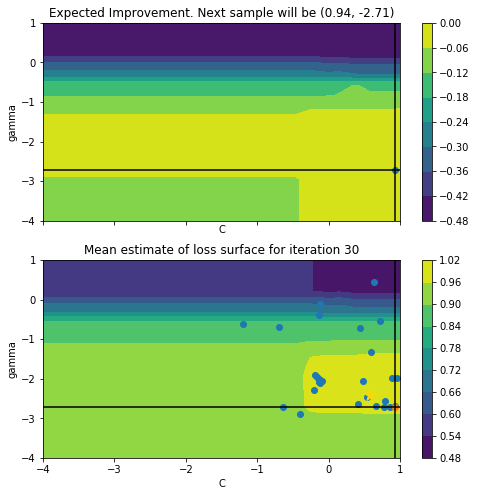

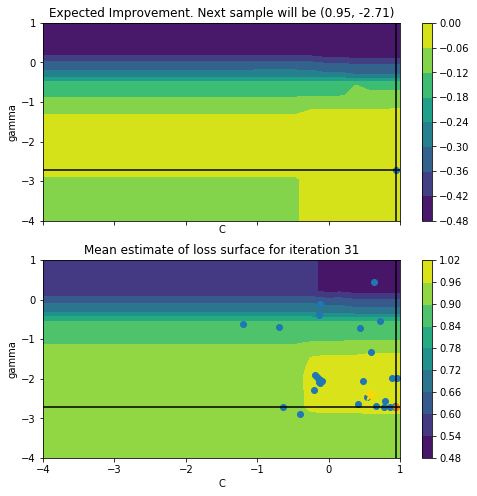

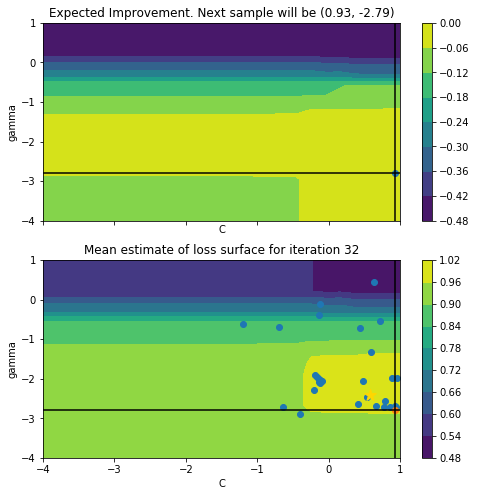

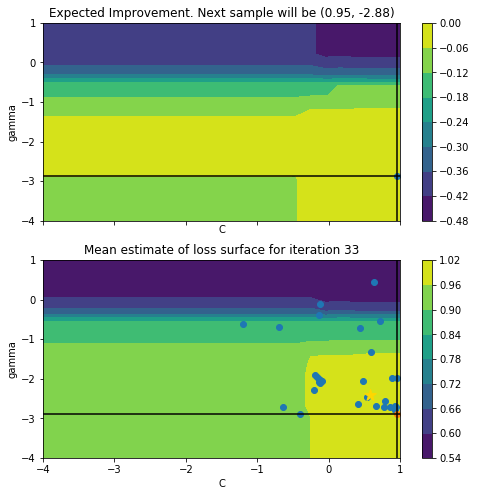

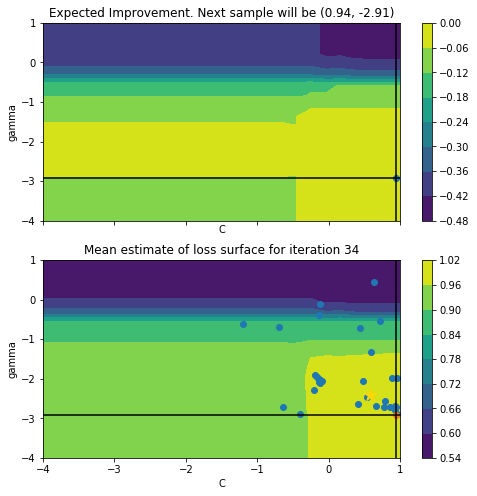

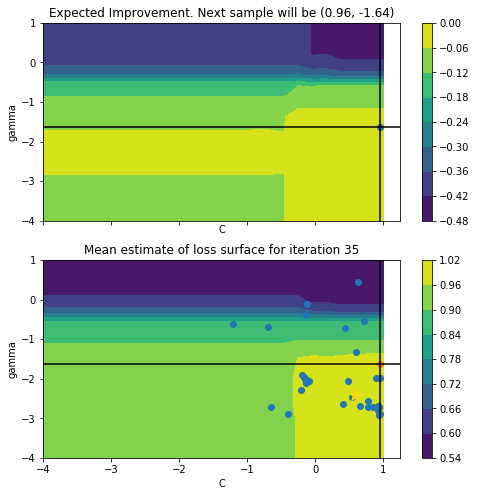

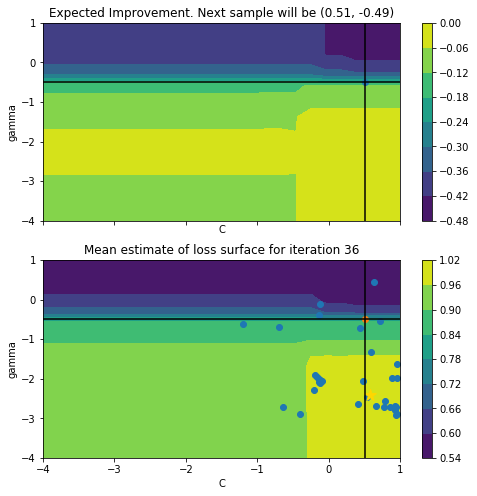

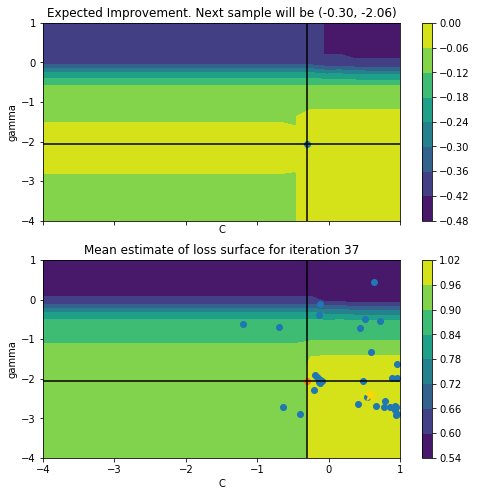

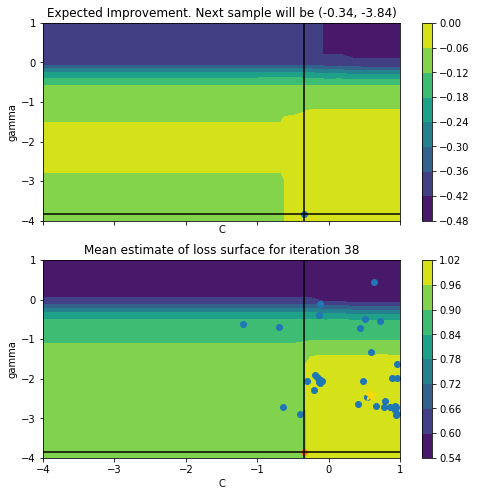

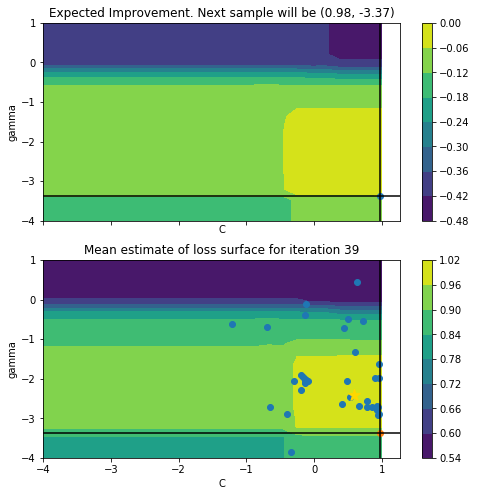

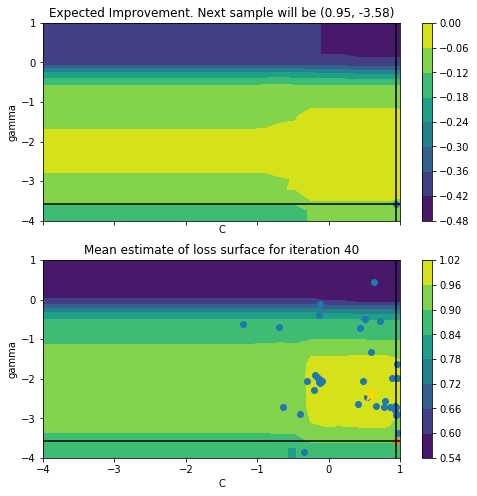

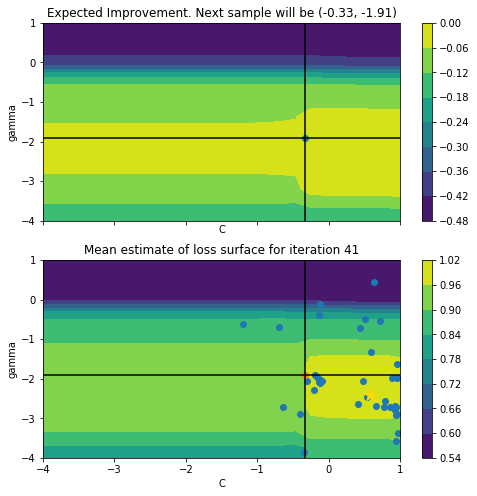

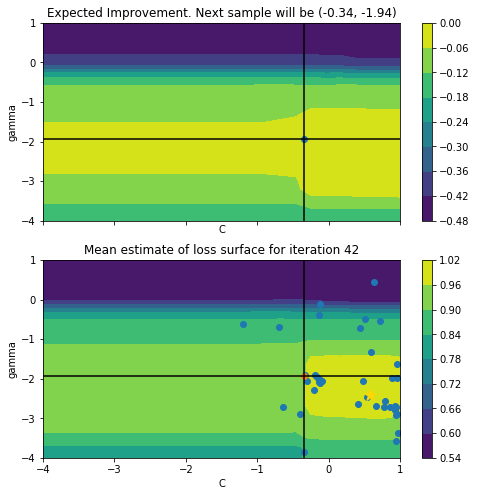

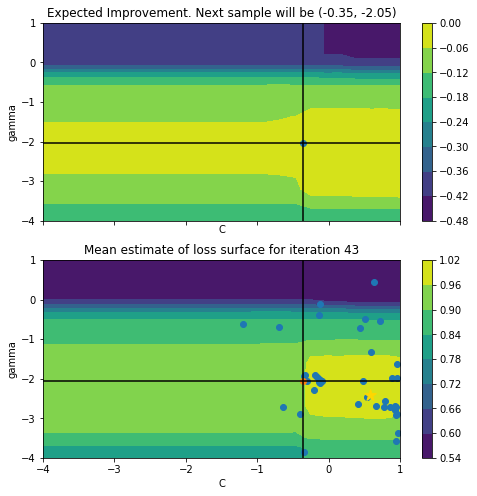

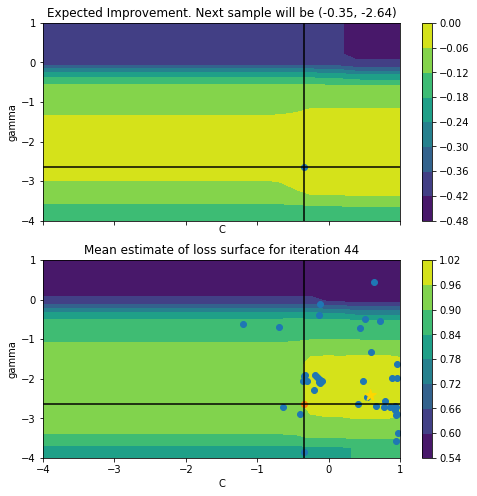

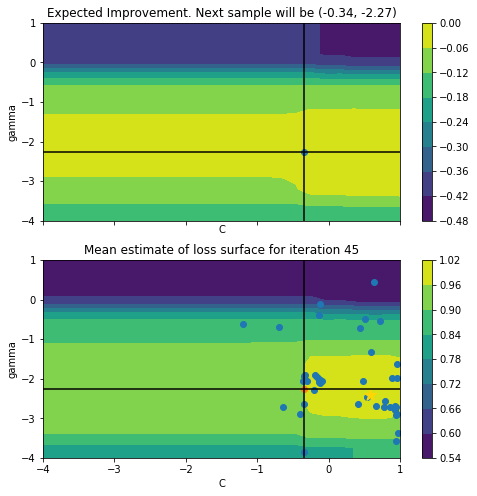

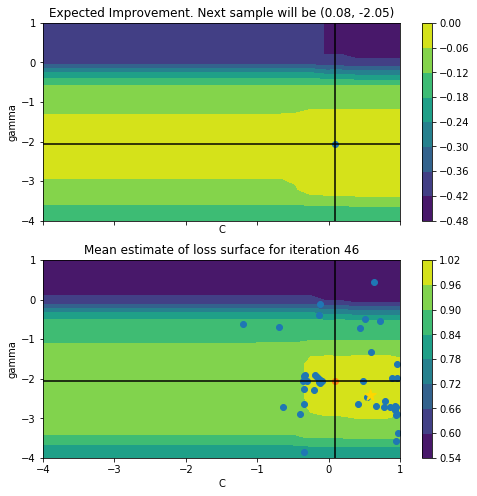

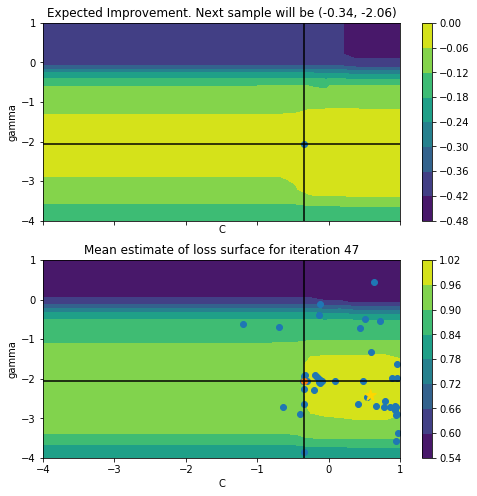

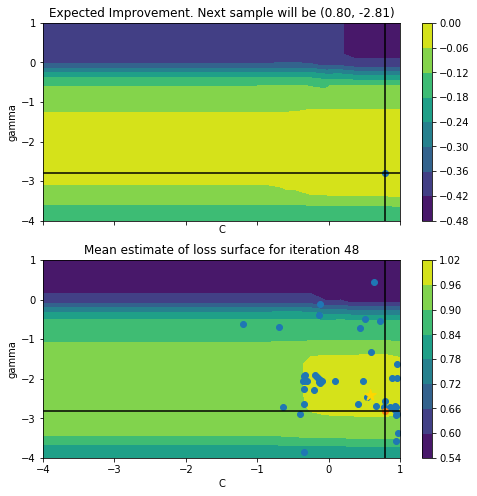

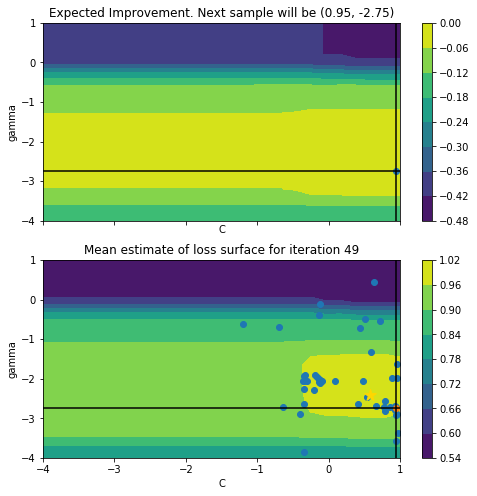

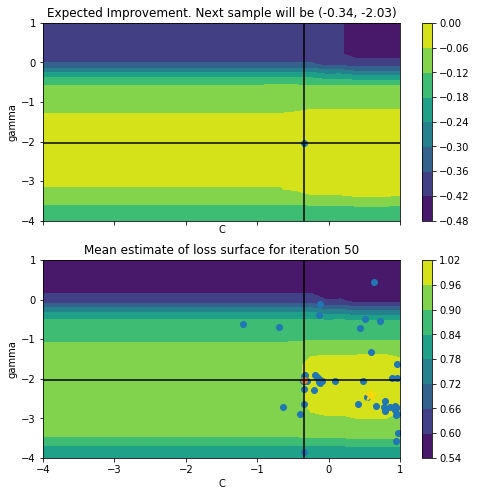

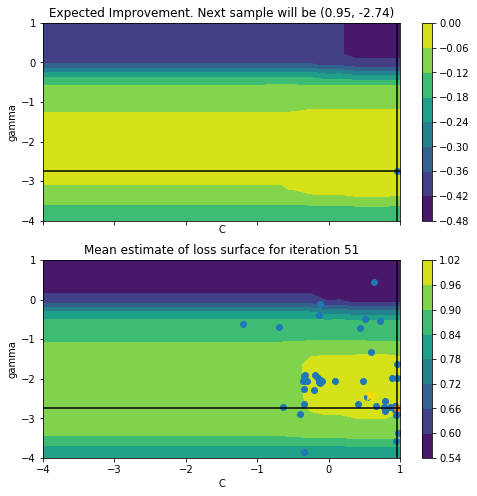

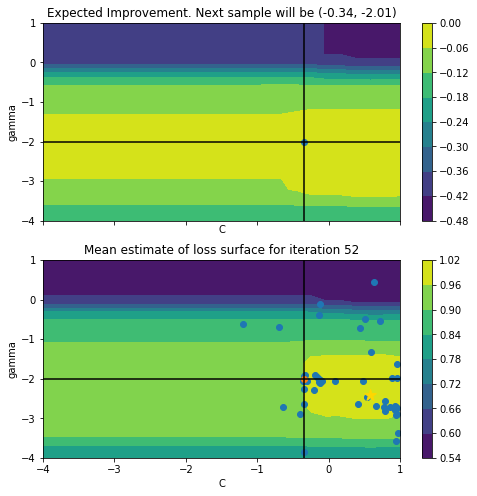

In [120]:
lambdas = np.linspace(1, -4, 25)
gammas = np.linspace(1, -4, 20)

plot_iteration(model_rf, lambdas, xp_rf, yp_rf, first_iter=3, 
               second_param_grid=gammas, optimum=[0.58333333, -2.42105263])

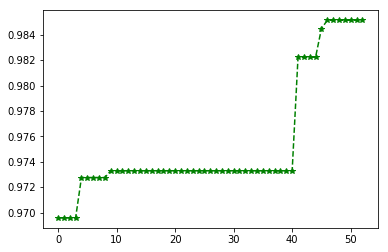

In [39]:
listy_rf = pltlist(yp_rf, greater_is_better = True)
plt.plot(listy_rf, '*g--')
plt.show()

## rand search

In [176]:
def RandomSearch(func, bounds, n_iter = 20):
    x_list = []
    y_list = []
    
    for params in np.random.uniform(bounds[:, 0], bounds[:, 1], (n_iter, bounds.shape[0])):
        x_list.append(params)
        y_list.append(func(params))
    x = np.array(x_list)
    y = np.array(y_list)
    return x, y
    

In [40]:
bounds = np.array([[-4, 4], [-4, 4]])

x_rs, y_rs = RandomSearch(sample_loss, bounds)

KeyboardInterrupt: 

In [ ]:
pltrngsearch = pltlist(y_rs)
plt.plot(pltrngsearch, 'g*--')
plt.show()